In [ ]:
!pip install datasets transformers nltk --quiet

     |████████████████████████████████| 451 kB 35.2 MB/s 
     |████████████████████████████████| 5.8 MB 88.3 MB/s 
     |████████████████████████████████| 182 kB 87.8 MB/s 
     |████████████████████████████████| 212 kB 93.3 MB/s 
     |████████████████████████████████| 132 kB 91.2 MB/s 
     |████████████████████████████████| 127 kB 95.5 MB/s 
     |████████████████████████████████| 7.6 MB 81.5 MB/s 


In [ ]:
import os 
import torch 
import numpy as np
import pandas as pd

from pathlib import Path 
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from transformers import TrainingArguments, Trainer, DataCollator
from datasets import load_dataset, load_metric

import nltk
nltk.download('punkt')
import seaborn as sns
from pprint import pprint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/nlp/train.csv')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/nlp/test.csv')

In [ ]:
train_df.columns

Index(['Unnamed: 0', 'keywords', 'Title', 'Article'], dtype='object')

In [ ]:
bos = '<|startoftitle|>'
eos = '<|EOS|>'
cls = '<|endoftitle|>'
prepare_text = lambda x: ' '.join([bos, x['Title'], cls , x['Article'], eos])
train_df['text'] = train_df.apply(prepare_text, axis=1)
test_df['text'] = test_df.apply(prepare_text, axis=1)

In [ ]:
train_df.to_csv('/content/drive/MyDrive/nlp/train_text.csv')
test_df.to_csv('/content/drive/MyDrive/nlp/test_text.csv')

In [ ]:
dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/nlp/train_text.csv',
                                              'test': '/content/drive/MyDrive/nlp/test_text.csv'})
dataset = dataset.remove_columns(["Unnamed: 0"])

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1d450b2cc8f42280/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'keywords', 'Title', 'Article', 'text'],
        num_rows: 4623
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'keywords', 'Title', 'Article', 'text'],
        num_rows: 119
    })
})

In [ ]:
train_df.dropna(inplace=True) #remove NA values
train_articles = train_df.Article.copy() #just use the main bio text in this example
train_articles

0       To prevent malpractice and improper business a...
1       Bhadravathi Police have arrested six people in...
2       On the eve of the midterm elections, 60 Minute...
3       UNITED NATIONS (AP) — The new U.N. special env...
4       eliveroo has immediately ended its operations ...
                              ...                        
4618    Six-year-old Charlie was found unresponsive at...
4619    There’s going to be a cosmological show early ...
4620    A man has been sentenced to three years jail t...
4621    Two days after the election, the identity of t...
4622    As the mandatory lock-in period for pre-IPO sh...
Name: Article, Length: 4623, dtype: object

In [ ]:
test_df.dropna(inplace=True)
test_articles = test_df.Article.copy()
test_articles

0      There’s a hard rule against candidates using l...
1      A strange phone call reveals a question from t...
2      In today’s fast-rising prices and interest rat...
3      ‘Sort Of’ is one of the most original, excitin...
4      This copy is for your personal non-commercial ...
                             ...                        
114    The IndependentIf they are anything like most ...
115    Microsoft's Xbox Game Pass Ultimate Perks now ...
116    The 2022 Canadian Football League regular seas...
117    Douglas is out this week so it’s just me, spea...
118    Meara is an associate editor on CNET's Culture...
Name: Article, Length: 119, dtype: object

In [ ]:
doc_lengths = []
test_doc_lengths = []
for article in train_articles:
    # get rough token count distribution
    tokens = nltk.word_tokenize(article)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

for article in test_articles:
    # get rough token count distribution
    tokens = nltk.word_tokenize(article)
    test_doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
test_doc_lengths = np.array(test_doc_lengths)

In [ ]:
np.max(doc_lengths)

5645

In [ ]:
np.max(test_doc_lengths)

5597

In [ ]:
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, set_seed
set_seed(42)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

In [ ]:
print("The max model length is {} for this model".format(tokenizer.model_max_length))

The max model length is 1024 for this model


In [ ]:
bos = '<|startoftitle|>'
eos = '<|EOS|>'
cls = '<|endoftitle|>'
pad = '<|pad|>'

special_tokens_dict = {'eos_token': eos, 'bos_token': bos, 'pad_token': pad, 'sep_token': cls}

num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)


config = GPT2Config.from_pretrained('gpt2-medium', 
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    sep_token_id=tokenizer.sep_token_id,
                                    output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained('gpt2-medium', config=config)
model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Embedding(50262, 1024)

In [ ]:
padding = True
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=1024,
            return_attention_mask=True,
            add_special_tokens=True,
            truncation=True,
            padding="max_length" if padding else False,
            pad_to_max_length=padding,
            return_tensors="pt")


tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["Article","Title","text",'keywords'])
columns = ['input_ids', 'attention_mask']
tokenized_dataset.set_format(type='torch', columns=columns)
tokenized_dataset

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'input_ids', 'attention_mask'],
        num_rows: 4623
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'input_ids', 'attention_mask'],
        num_rows: 119
    })
})

In [ ]:
tokenized_dataset['train'][0]

{'input_ids': tensor([50258,   496,   285,  ..., 50259, 50259, 50259]),
 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0])}

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# training_args.num_train_epochs = 3
# training_args.per_device_train_batch_size=1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(tokenized_dataset['train'], shuffle=True, batch_size=2)
eval_dataloader = DataLoader(tokenized_dataset['test'], shuffle=True, batch_size=2)

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 15
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50262, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [ ]:
val_loss = []
def evaluate(model, eval_dataloader):
  model.eval()
  with torch.no_grad():
      e_loss = 0.0
  for batch in eval_dataloader:
        ids = batch["input_ids"].to(device, dtype=torch.long)
        lm_labels = batch["input_ids"].to(device, dtype=torch.long)
        mask = batch["attention_mask"].to(device, dtype=torch.long)
        outputs = model(input_ids=ids,
                        attention_mask=mask,
                        labels=lm_labels)
        
        loss = outputs[0]
        e_loss += (loss.cpu().detach())
  val_loss.append(e_loss/len(eval_dataloader))

In [ ]:
#TRAINING LOOP
from tqdm.auto import tqdm
train_loss = []
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    t_loss = 0.0
    for batch in train_dataloader:
        ids = batch["input_ids"].to(device, dtype=torch.long)
        lm_labels = batch["input_ids"].to(device, dtype=torch.long)
        mask = batch["attention_mask"].to(device, dtype=torch.long)
        outputs = model(input_ids=ids,
                        attention_mask=mask,
                        labels=lm_labels)
        
        loss = outputs[0]
        t_loss += (loss.cpu().detach())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_loss.append(t_loss/len(train_dataloader))
    evaluate(model, eval_dataloader)

  0%|          | 0/34680 [00:00<?, ?it/s]

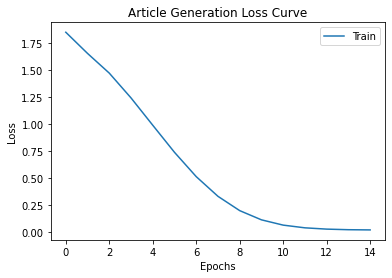

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
y = np.arange(0, num_epochs)
plt.title("Article Generation Loss Curve")
plt.plot(y, train_loss, label="Train")
#plt.plot(y, val_loss, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from tensorflow.python.ops.gen_logging_ops import print_v2_eager_fallback
headlines = ["Oil prices rise after drone attack on tanker owned by Israeli tycoon", "How to create an account on Mastodon, a Twitter alternative",]

MAX_LEN = 200

articles = {}
for headline in headlines:
  headline_c = ' '.join([bos, headline,  body])
  input = tokenizer(headline_c, return_tensors="pt", padding=True)
  article = model.generate(
      input_ids=input["input_ids"].to(device, dtype=torch.long),
      attention_mask=input["attention_mask"].to(device, dtype=torch.long),
      do_sample=True,
      max_length = MAX_LEN,
  )
  decoded_article = tokenizer.decode(article[0], skip_special_tokens=True)
  articles[headline] = decoded_article.replace(headline, '')

for title, article in articles.items():
    print('TITLE:', title)
    print('ARTICLE:', article)
    #pprint('ARTICLE_P:', article)
    print('\n')


TITLE: Oil prices rise after drone attack on tanker owned by Israeli tycoon
ARTICLE: The price of oil increased by more than 30% after a drone attacked a tanker owned by an Israeli billionaire, according to a tweet from the Israeli oil shipping company ShippingLines.The drone “slammed” the vessel’s hull, according to a company statement. It made its way to the west coast of Israel before crashing into the Pacific Ocean.An Israeli official was quick to condemn the attack. “We will actively pursue all means necessary to prevent such attacks in the future,” said Israeli Shipping Minister Yoav Galant, according to the Jerusalem Post. The trucking company, which is owned by Haim Bodkin, is one of the top ten privately owned shipping operators operating in the world.Bodkin and his company are part of Group E of the shipping giant Maersk Group. According to the UN Refugee Agency, over one million people have been displaced by maritime disasters


TITLE: How to create an account on Mastodon, a

In [ ]:
modelsavename= "/content/drive/MyDrive/nlp/article_generation.pt"  # change the name here to save in a specific file (and restore below)
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/nlp/article_generation_token")

('/content/drive/MyDrive/nlp/article_generation_token/tokenizer_config.json',
 '/content/drive/MyDrive/nlp/article_generation_token/special_tokens_map.json',
 '/content/drive/MyDrive/nlp/article_generation_token/vocab.json',
 '/content/drive/MyDrive/nlp/article_generation_token/merges.txt',
 '/content/drive/MyDrive/nlp/article_generation_token/added_tokens.json')

In [ ]:
model.config.to_json_file("/content/drive/MyDrive/nlp/config.json")

In [ ]:
model.save_pretrained("/content/drive/MyDrive/nlp/article_generation")